In [1]:
import numpy as np
import cv2
import math
import numpy.random
import matplotlib.pyplot as plt
import statistics

dt = 0.01
measurementSigma = 0.05     # Среднеквадратичное отклонение датчика (0.5)
measurementSigma_sin = 0.05
processNoiseVariance = 1e-4      # Ошибка модели, дисперсия (спектральная плотность белого шума)

class Disc:
    def __init__(self, x, y, r, color, I, dt, a0 = 0, a_dot0 = 0):
        self.x = x
        self.y = y
        self.r = r
        self.color = color

        self.I = I
        self.dt = dt
        
        #x
        self.a     = a0 #alpha
        self.a_dot = a_dot0
    
    def draw(self, canvas):
        cv2.circle(canvas, (self.x, self.y), self.r, self.color, -1)
        cv2.line(canvas, (self.x, self.y), (int(self.x + self.r * 1.3 * math.cos(self.a)),
                int(self.y + self.r * 1.3 * math.sin(self.a))), (223, 123, 78), 3)
    
    def calc_dyn(self, tau):
        a_ddot = tau / self.I
        
        self.a_dot += a_ddot * self.dt
        self.a += self.a_dot * self.dt
        
        #print(self.a)
    
    def get_observation(self):
        #return self.a + np.random.random_sample() / 3
         return self.a + np.random.normal(0.0, measurementSigma)
        
    def get_observation_sin(self):
        #return self.a + np.random.random_sample() / 3
         return math.sin(self.a) + np.random.normal(0.0, measurementSigma_sin)

canvas = np.ones((600, 600, 3), np.uint8) * 50

disc = Disc(300, 300, 150, (123, 223, 45), 15, dt, a_dot0 = 18)

i = 0

obs = []
obs_sin = []
true_a = []

#KF: alpha, alpha_dot

while(True):
    canvas[:, :, :] = 50
    
    tau = 0 #1080 * math.sin(i / 20.0))
    disc.calc_dyn(tau)
    disc.draw(canvas)
    
    y = disc.get_observation()
    obs.append(y)
    
    y_sin = disc.get_observation_sin()
    obs_sin.append(y_sin)
    
    alpha = disc.a
    true_a.append(alpha)
    
    #KF <- y
    
    cv2.imshow("canvas", canvas)
    
    key = cv2.waitKey(30) & 0xFF
    
    i += 1
    
    if (key == ord('q')):
        break

cv2.destroyAllWindows()
cv2.waitKey(10)

2024-04-26 23:54:35.382 Python[42466:6660052] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


-1

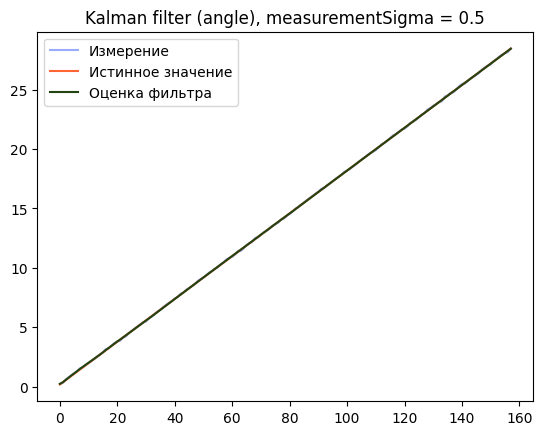

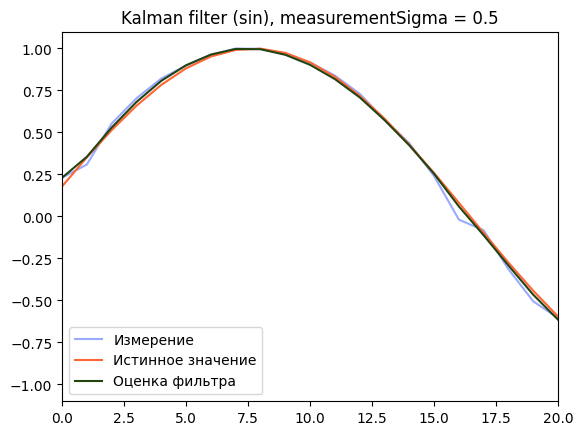

In [3]:
import filterpy.kalman
import filterpy.common


# Создаём объект KalmanFilter
filter = filterpy.kalman.KalmanFilter(dim_x=2,      # Размер вектора стостояния
                                     dim_z=1)      # Размер вектора измерений

# F - матрица процесса - размер dim_x на dim_x - 3х3
filter.F = np.array([[1.0,   dt],
                     [0,   1.0]])


# Матрица наблюдения - dim_z на dim_x - 1x3
filter.H = np.array([[1.0, 0.0]])

# Ковариационная матрица ошибки модели
filter.Q = filterpy.common.Q_discrete_white_noise(dim=2, dt=dt, var=processNoiseVariance) #var - дисперсия (спетральная плотность белого шума)

# Ковариационная матрица ошибки измерения - 1х1
filter.R = np.array([[measurementSigma*measurementSigma]])

# Начальное состояние.
filter.x = np.array([0.0, 18.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[0.5, 0.0],
                    [0.0,  0.5]])

filteredState = []

# Обработка данных
for i in range(0, len(obs)):
   z = [ obs[i] ]                      # Вектор измерений
   filter.predict()                            # Этап предсказания
   filter.update(z)                            # Этап коррекции

   filteredState.append(filter.x)

filteredState = np.array(filteredState)
filteredState = filteredState[:, 0]

# Визуализация
plt.title("Kalman filter (angle), measurementSigma = 0.5")
plt.plot(obs, label="Измерение", color="#99AAFF")
plt.plot(true_a, label="Истинное значение", color="#FF6633")
plt.plot(filteredState, label="Оценка фильтра", color="#224411")
plt.legend()
plt.show()


sin_obs = [ math.sin(obs[i]) for i in range (len(obs)) ]
sin_true_a = [ math.sin(true_a[i]) for i in range (len(true_a)) ]
sin_filteredState = [ math.sin(filteredState[i]) for i in range (len(filteredState)) ]

fig, ax = plt.subplots()


plt.title("Kalman filter (sin), measurementSigma = 0.5")
ax.plot(sin_obs, label="Измерение", color="#99AAFF")
ax.plot(sin_true_a, label="Истинное значение", color="#FF6633")
ax.plot(sin_filteredState, label="Оценка фильтра", color="#224411")
#plt.ylim([-1.5, 2.0])
plt.xlim([0, 20])
plt.legend()
plt.show()

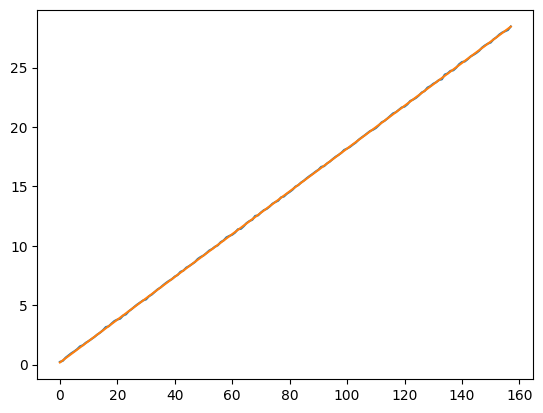

In [4]:
plt.plot(obs)
plt.plot(true_a)
plt.show()

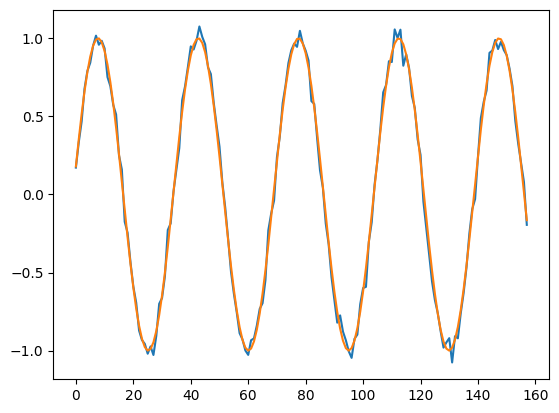

In [5]:
plt.plot(obs_sin)
plt.plot(sin_true_a)
plt.show()

## Что делать с нелинейными системами? Фильтр Калмана "Без запаха"

Здесь пишем сигма-точечный (без запаха) Фильтр Калмана для линейной системы, чтобы посмотреть, что он работает)

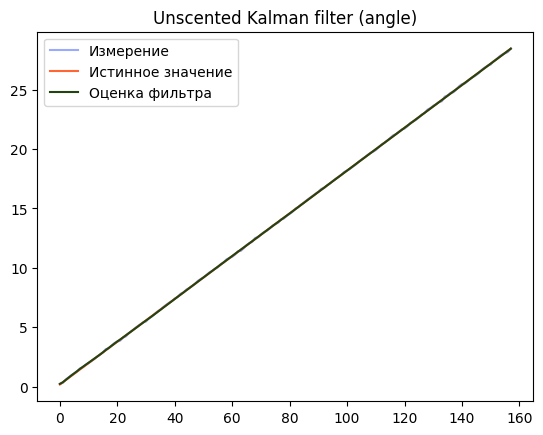

In [6]:
# Функция наблюдения - аналог матрицы наблюдения
# Преобразует вектор состояния x в вектор измерений z
def measurementFunction(x):
   return np.array([x[0]])

#Функция процесса - аналог матрицы процесса
def stateTransitionFunction(x, dt):
   newState = np.zeros(2)
   newState[0] = x[0] + dt * x[1]
   newState[1] = x[1]

   return newState

# Для unscented kalman filter необходимо выбрать алгоритм выбора сигма-точек
points = filterpy.kalman.JulierSigmaPoints(2, kappa=0)

# Создаём объект UnscentedKalmanFilter
filter = filterpy.kalman.UnscentedKalmanFilter(dim_x = 2,
                                              dim_z = 1,
                                              dt = dt,
                                              hx = measurementFunction,
                                              fx = stateTransitionFunction,
                                              points = points)


# Ковариационная матрица ошибки модели
filter.Q = filterpy.common.Q_discrete_white_noise(dim=2, dt=dt, var=processNoiseVariance)

# Ковариационная матрица ошибки измерения - 1х1
filter.R = np.array([[measurementSigma*measurementSigma]])

# Начальное состояние.
filter.x = np.array([0.0, 18.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[0.5, 0.0],
                     [0.0, 0.5]])

filteredState = []
stateCovarianceHistory = []

for i in range(0, len(obs)):
   z = [ obs[i] ]
   filter.predict()
   filter.update(z)

   filteredState.append(filter.x)
   stateCovarianceHistory.append(filter.P)

filteredState = np.array(filteredState)
stateCovarianceHistory = np.array(stateCovarianceHistory)

plt.title("Unscented Kalman filter (angle)")
plt.plot(obs, label="Измерение", color="#99AAFF")
plt.plot(true_a, label="Истинное значение", color="#FF6633")
plt.plot(filteredState[:, 0], label="Оценка фильтра", color="#224411")
plt.legend()
plt.show()

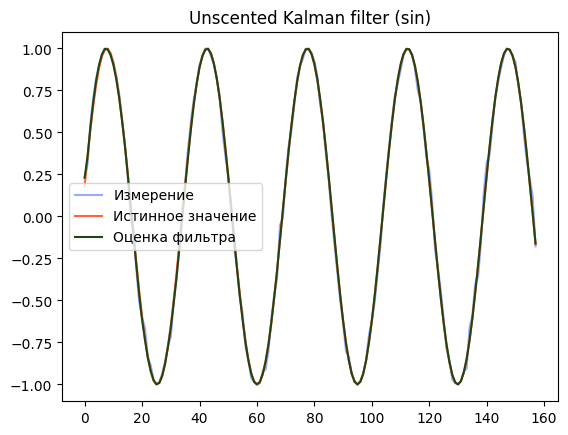

In [7]:
sin_filteredState = filteredState[:, 0]
sin_filteredState = [ math.sin(sin_filteredState[i]) for i in range (len(sin_filteredState)) ]

plt.title("Unscented Kalman filter (sin)")
plt.plot(sin_obs, label="Измерение", color="#99AAFF")
plt.plot(sin_true_a, label="Истинное значение", color="#FF6633")
plt.plot(sin_filteredState, label="Оценка фильтра", color="#224411")
plt.legend()
plt.show()

Здесь пробуем уже для нелинейной системы, где наблюдение - это sin

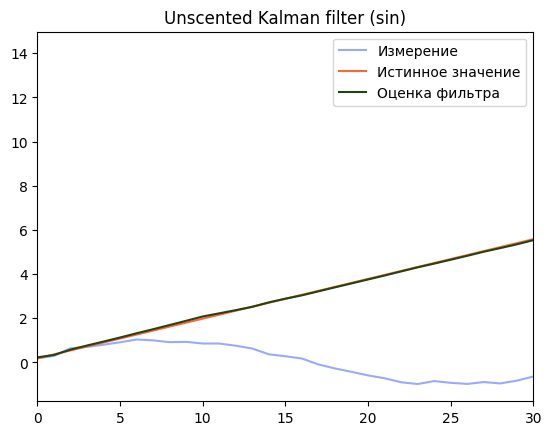

In [38]:
# Функция наблюдения - аналог матрицы наблюдения
# Преобразует вектор состояния x в вектор измерений z
def measurementFunction(x):
    #y = []
    #y = np.array([x[0]])
    #y = [ math.sin(y[i]) for i in range (len(y)) ]
    
   return np.array([math.sin(x[0])])

#Функция процесса - аналог матрицы процесса
def stateTransitionFunction(x, dt):
   newState = np.zeros(2)
   newState[0] = x[0] + dt * x[1]
   newState[1] = x[1]

   return newState

# Для unscented kalman filter необходимо выбрать алгоритм выбора сигма-точек
points = filterpy.kalman.JulierSigmaPoints(2, kappa=0)

# Создаём объект UnscentedKalmanFilter
filter = filterpy.kalman.UnscentedKalmanFilter(dim_x = 2,
                                              dim_z = 1,
                                              dt = dt,
                                              hx = measurementFunction,
                                              fx = stateTransitionFunction,
                                              points = points)


# Ковариационная матрица ошибки модели
filter.Q = filterpy.common.Q_discrete_white_noise(dim=2, dt=dt, var=processNoiseVariance)

# Ковариационная матрица ошибки измерения - 1х1
filter.R = np.array([[measurementSigma_sin*measurementSigma_sin]])

# Начальное состояние.
filter.x = np.array([0.0, 18.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[0.5, 0.0],
                     [0.0, 0.5]])

filteredState = []
stateCovarianceHistory = []

for i in range(0, len(obs_sin)):
   z = [ obs_sin[i] ]
   filter.predict()
   filter.update(z)

   filteredState.append(filter.x)
   stateCovarianceHistory.append(filter.P)

filteredState = np.array(filteredState)
stateCovarianceHistory = np.array(stateCovarianceHistory)

plt.title("Unscented Kalman filter (sin)")
plt.plot(obs_sin, label="Измерение", color="#99AAFF")
plt.plot(true_a, label="Истинное значение", color="#FF6633")
plt.plot(filteredState[:, 0], label="Оценка фильтра", color="#224411")
#plt.ylim([-1.5, 2.0])
plt.xlim([0, 30])
plt.legend()
plt.show()